## Host VS NON-Host stars 


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from pathlib import Path

## Logistic regression

In [6]:
# Load full cleaned data
stars = pd.read_csv("../../data/full/stars_gaia_clean.csv").assign(label=0)
exo = pd.read_csv("../../data/full/exoplanets_clean.csv").assign(label=1)

# Align columns: exoplanets use sy_plx for parallax
exo = exo.rename(columns={"sy_plx": "parallax"})

# Shared features
features = ["ra", "dec", "parallax"]

# Define sizes (balanced by smallest class)
sizes = [1000, 3000, 10000]

def eval_size(n_total, n_splits=100):
    n_per = min(n_total // 2, len(exo), len(stars))
    exo_sub = exo.sample(n=n_per, random_state=42)
    stars_sub = stars.sample(n=n_per, random_state=42)

    df = pd.concat([exo_sub, stars_sub], ignore_index=True)

    # Ensure numeric + drop only missing feature rows
    df[features] = df[features].apply(pd.to_numeric, errors="coerce")
    df = df.dropna(subset=features)

    X = df[features].values
    y = df["label"].values

    splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    accs = []; precs = []; recs = []; f1s = []

    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))
    for train_idx, test_idx in splitter.split(X, y):
        clf.fit(X[train_idx], y[train_idx])
        y_pred = clf.predict(X[test_idx])
        accs.append(accuracy_score(y[test_idx], y_pred))
        p, r, f1, _ = precision_recall_fscore_support(
            y[test_idx], y_pred, average="binary", zero_division=0
        )
        precs.append(p); recs.append(r); f1s.append(f1)

    return {
        "size": 2 * n_per,
        "acc_mean": float(np.mean(accs)),
        "prec_mean": float(np.mean(precs)),
        "rec_mean": float(np.mean(recs)),
        "f1_mean": float(np.mean(f1s))
    }

for size in sizes:
    print(eval_size(size))

{'size': 1000, 'acc_mean': 0.8936, 'prec_mean': 0.878476810062675, 'rec_mean': 0.9144999999999999, 'f1_mean': 0.8957430793972189}
{'size': 3000, 'acc_mean': 0.9042833333333333, 'prec_mean': 0.882259085907448, 'rec_mean': 0.9334666666666667, 'f1_mean': 0.9070195703092585}
{'size': 10000, 'acc_mean': 0.9049299999999999, 'prec_mean': 0.878767488137457, 'rec_mean': 0.9395799999999999, 'f1_mean': 0.9081223803783645}


## Increased the n_splits to 100 using Random_forest 

In [7]:
def eval_size_rf(n_total, n_splits=100):
    n_per = min(n_total // 2, len(exo), len(stars))
    exo_sub = exo.sample(n=n_per, random_state=42)
    stars_sub = stars.sample(n=n_per, random_state=42)

    df = pd.concat([exo_sub, stars_sub], ignore_index=True)
    df[features] = df[features].apply(pd.to_numeric, errors="coerce")
    df = df.dropna(subset=features)

    X = df[features].values
    y = df["label"].values

    splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    accs = []; precs = []; recs = []; f1s = []

    for train_idx, test_idx in splitter.split(X, y):
        clf = RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            class_weight="balanced_subsample"
        )
        clf.fit(X[train_idx], y[train_idx])
        y_pred = clf.predict(X[test_idx])
        accs.append(accuracy_score(y[test_idx], y_pred))
        p, r, f1, _ = precision_recall_fscore_support(
            y[test_idx], y_pred, average="binary", zero_division=0
        )
        precs.append(p); recs.append(r); f1s.append(f1)

    return {
        "size": 2 * n_per,
        "acc_mean": float(np.mean(accs)),
        "prec_mean": float(np.mean(precs)),
        "rec_mean": float(np.mean(recs)),
        "f1_mean": float(np.mean(f1s))
    }
for size in sizes:
    print(eval_size_rf(size))

{'size': 1000, 'acc_mean': 0.99205, 'prec_mean': 0.9914898035023143, 'rec_mean': 0.9926999999999999, 'f1_mean': 0.9920547589488632}
{'size': 3000, 'acc_mean': 0.9957833333333334, 'prec_mean': 0.9964742362195719, 'rec_mean': 0.9951000000000001, 'f1_mean': 0.9957798758664138}
{'size': 10000, 'acc_mean': 0.9984300000000002, 'prec_mean': 0.9984219307756844, 'rec_mean': 0.9984400000000001, 'f1_mean': 0.9984301832293386}


## Plotting reaults fir Accuracy, precision, Recall, F1 Score


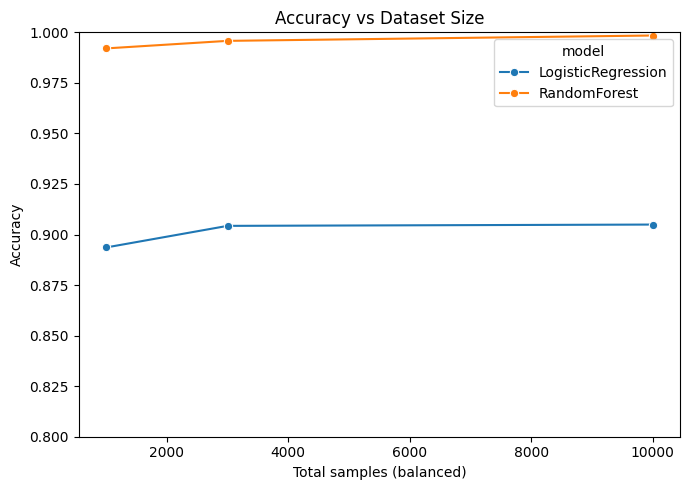

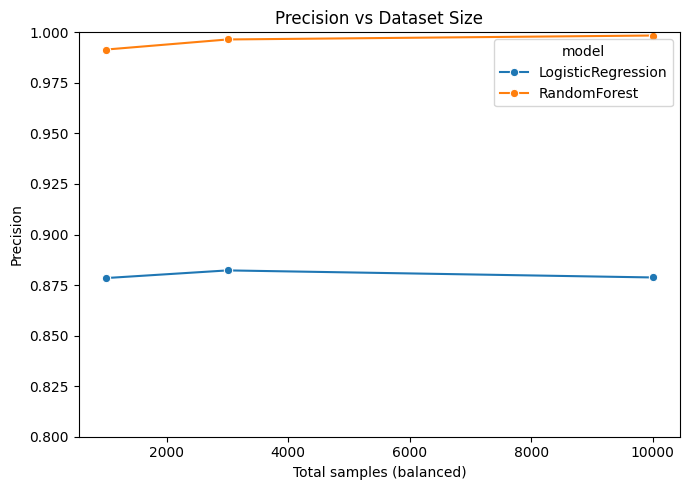

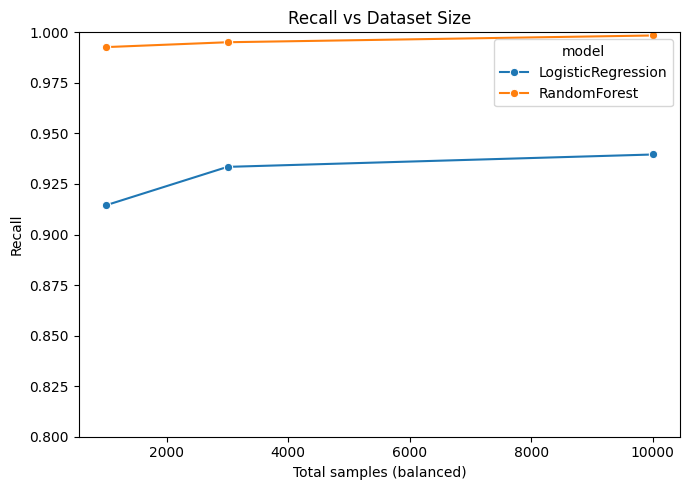

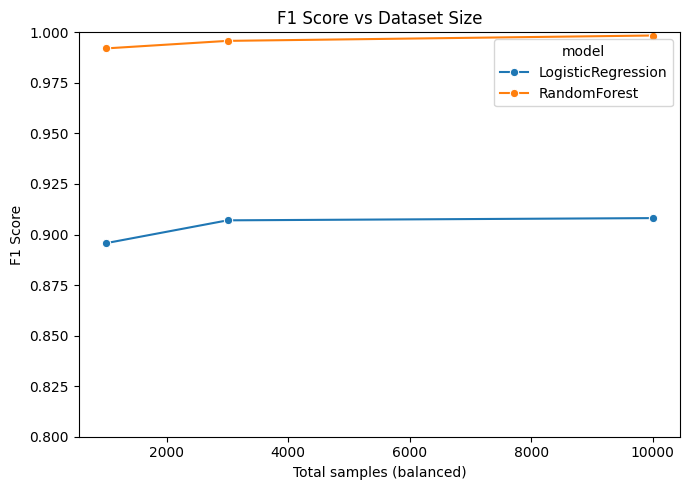

In [8]:
logreg_results = [eval_size(n) for n in sizes]
rf_results = [eval_size_rf(n) for n in sizes]

df_log = pd.DataFrame(logreg_results)
df_log["model"] = "LogisticRegression"

df_rf = pd.DataFrame(rf_results)
df_rf["model"] = "RandomForest"

df_plot = pd.concat([df_log, df_rf], ignore_index=True)

plot_dir = Path("../../Main_plots/binary_host_vs_nonhost_stars")
plot_dir.mkdir(parents=True, exist_ok=True)

metrics = ["acc_mean", "prec_mean", "rec_mean", "f1_mean"]
titles = {
    "acc_mean": "Accuracy",
    "prec_mean": "Precision",
    "rec_mean": "Recall",
    "f1_mean": "F1 Score",
}

for m in metrics:
    plt.figure(figsize=(7,5))
    sns.lineplot(data=df_plot, x="size", y=m, hue="model", marker="o")
    plt.title(f"{titles[m]} vs Dataset Size")
    plt.xlabel("Total samples (balanced)")
    plt.ylabel(titles[m])
    plt.ylim(0.8, 1.0)  
    plt.tight_layout()
    plt.savefig(plot_dir / f"{m}_vs_size.png", dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()